# Cell processing, clustering and annotation from CellSeg output

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
from scipy.sparse import csr_matrix

In [19]:
dat = pd.read_csv("../../Data/test/region1-output/quantifications/data.tif_statistics_growth_5_comp.csv", index_col=0)
dat.head()

Reg  Tile Row  Tile Col  Tile Z   In-Tile Y   In-Tile X  Absolute Y  \
Cell                                                                        
1.0   0.0       1.0       1.0     0.0  300.151292   25.738007  300.151292   
2.0   0.0       1.0       1.0     0.0  642.152727  136.381818  642.152727   
3.0   0.0       1.0       1.0     0.0  342.239044  201.011952  342.239044   
4.0   0.0       1.0       1.0     0.0  194.625000  251.668919  194.625000   
5.0   0.0       1.0       1.0     0.0  679.453642  504.993377  679.453642   

      Absolute X  Cell Size       DAPI  ...     CD45RA  Mac2Gal3        CD4  \
Cell                                    ...                                   
1.0    25.738007      543.0  25.426964  ...   7.319881  6.835181  11.502511   
2.0   136.381818      436.0  30.011424  ...   9.906308  0.182763   0.000000   
3.0   201.011952      408.0  27.011034  ...   7.271998  3.282573  10.286796   
4.0   251.668919      552.0  18.980330  ...  19.987217  7.405513   3.637845   
5.0   504.993377      511.0  21.304212  ...   0.000000  1.427489   1.897285   

      Granzyme B       CD21       CD3e      CD15      CD34      CD31  \
Cell                                                                   
1.0     2.589094   0.869051  15.170402  1.115761  1.359888  1.529837   
2.0     0.776616   1.245482   9.527366  0.757032  0.000000  1.574128   
3.0     0.681793   2.333215  14.069486  0.976715  0.000000  1.187418   
4.0     2.717171  10.615281   3.234538  0.000000  1.660936  2.114088   
5.0     0.810440   0.000000   5.763633  0.674488  0.579477  2.425490   

       Vimentin  
Cell             
1.0   19.203017  
2.0   40.604405  
3.0   90.991063  
4.0   35.098062  
5.0   28.419927  

[5 rows x 53 columns]

In [20]:
# need to drop BCL-6 and CD-30--artifacts
dat.drop(columns=['BCL-6', 'CD30'], inplace=True)

In [21]:
dat.iloc[187939:187950,:]

Reg  Tile Row  Tile Col  Tile Z   In-Tile Y   In-Tile X  Absolute Y  \
Cell                                                                        
1.0   0.0       1.0       1.0     0.0  300.151292   25.738007  300.151292   
2.0   0.0       1.0       1.0     0.0  642.152727  136.381818  642.152727   
3.0   0.0       1.0       1.0     0.0  342.239044  201.011952  342.239044   
4.0   0.0       1.0       1.0     0.0  194.625000  251.668919  194.625000   
5.0   0.0       1.0       1.0     0.0  679.453642  504.993377  679.453642   
6.0   0.0       1.0       1.0     0.0   99.094801  219.975535   99.094801   
7.0   0.0       1.0       1.0     0.0   30.261261  363.252252   30.261261   
8.0   0.0       1.0       1.0     0.0  276.606250  566.803125  276.606250   
9.0   0.0       1.0       1.0     0.0  504.904762  672.532468  504.904762   
10.0  0.0       1.0       1.0     0.0  367.979885  279.459770  367.979885   
11.0  0.0       1.0       1.0     0.0  257.306818  535.744318  257.306818   

      Absolute X  Cell Size       DAPI  ...     CD45RA   Mac2Gal3        CD4  \
Cell                                    ...                                    
1.0    25.738007      543.0  25.426964  ...   7.319881   6.835181  11.502511   
2.0   136.381818      436.0  30.011424  ...   9.906308   0.182763   0.000000   
3.0   201.011952      408.0  27.011034  ...   7.271998   3.282573  10.286796   
4.0   251.668919      552.0  18.980330  ...  19.987217   7.405513   3.637845   
5.0   504.993377      511.0  21.304212  ...   0.000000   1.427489   1.897285   
6.0   219.975535      447.0  22.644826  ...  15.702022   0.000000   3.406905   
7.0   363.252252      432.0  16.767698  ...  18.267416  10.319808   4.502521   
8.0   566.803125      520.0  12.808065  ...  16.713977  58.176039   1.284399   
9.0   672.532468      417.0  22.930685  ...  10.629235   5.838243   0.000000   
10.0  279.459770      625.0  26.049185  ...   3.384556  13.468605   8.879999   
11.0  535.744318      318.0   9.983216  ...  16.798510  12.028098  14.469247   

      Granzyme B       CD21       CD3e      CD15      CD34      CD31  \
Cell                                                                   
1.0     2.589094   0.869051  15.170402  1.115761  1.359888  1.529837   
2.0     0.776616   1.245482   9.527366  0.757032  0.000000  1.574128   
3.0     0.681793   2.333215  14.069486  0.976715  0.000000  1.187418   
4.0     2.717171  10.615281   3.234538  0.000000  1.660936  2.114088   
5.0     0.810440   0.000000   5.763633  0.674488  0.579477  2.425490   
6.0     2.136319   8.160473   1.576058  1.318804  0.840855  1.321193   
7.0     1.190329   4.533557   8.325514  0.812031  1.360830  2.845791   
8.0     1.060401   0.301260  15.396111  0.665593  0.097443  3.913063   
9.0     0.798433   1.638028   5.729877  0.964693  0.097138  2.476108   
10.0    2.081030   0.799983   6.434218  0.833806  0.571155  0.260711   
11.0    1.606640   1.766807   9.673531  0.901652  0.608237  1.479395   

       Vimentin  
Cell             
1.0   19.203017  
2.0   40.604405  
3.0   90.991063  
4.0   35.098062  
5.0   28.419927  
6.0   41.633560  
7.0   48.985767  
8.0   79.822218  
9.0    1.735501  
10.0  33.759857  
11.0  67.002805  

[11 rows x 53 columns]

In [21]:
dat.index = dat.index.map(str)

(array([4.52000e+04, 1.26812e+05, 1.47220e+04, 1.09500e+03, 9.90000e+01,
        3.00000e+00, 4.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  21.,  252.,  483.,  714.,  945., 1176., 1407., 1638., 1869.,
        2100., 2331.]),
 <BarContainer object of 10 artists>)

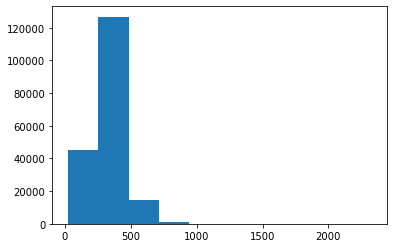

In [4]:
plt.hist(dat['Cell Size'])

In [5]:
np.where(dat.columns=="DAPI")

(array([9]),)

In [22]:
counts = csr_matrix(np.array(dat.iloc[:,9:]))

In [23]:
adata = ad.AnnData(counts)

In [24]:
adata.obs_names = dat.index
adata.var_names = list(dat.columns[9:])

In [25]:
adata.obs = dat.iloc[:,0:9]

In [10]:
adata

AnnData object with n_obs × n_vars = 375878 × 44
    obs: 'Reg', 'Tile Row', 'Tile Col', 'Tile Z', 'In-Tile Y', 'In-Tile X', 'Absolute Y', 'Absolute X', 'Cell Size'

## Now doing the processing

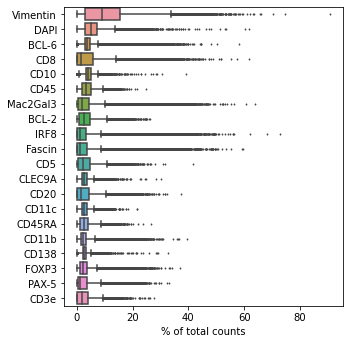

In [9]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [26]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


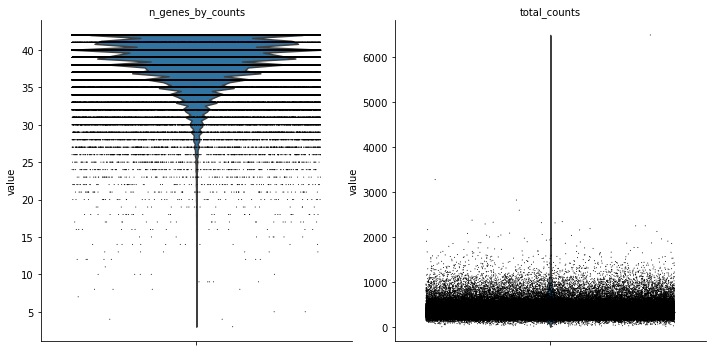

In [27]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

In [28]:
adata = adata[adata.obs.n_genes_by_counts > 20, :]
adata = adata[adata.obs.total_counts < 2000, :]

In [16]:
dat['CD5'].sum()

2115204.718134766

In [19]:
adata.obs_names

Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0',
       ...
       '187930.0', '187931.0', '187932.0', '187933.0', '187934.0', '187935.0',
       '187936.0', '187937.0', '187938.0', '187939.0'],
      dtype='object', name='Cell', length=375594)

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
adata.raw = adata

In [31]:
sc.pp.scale(adata)

In [32]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [23]:
sc.tl.leiden(adata, resolution = 0.5)

IOStream.flush timed out


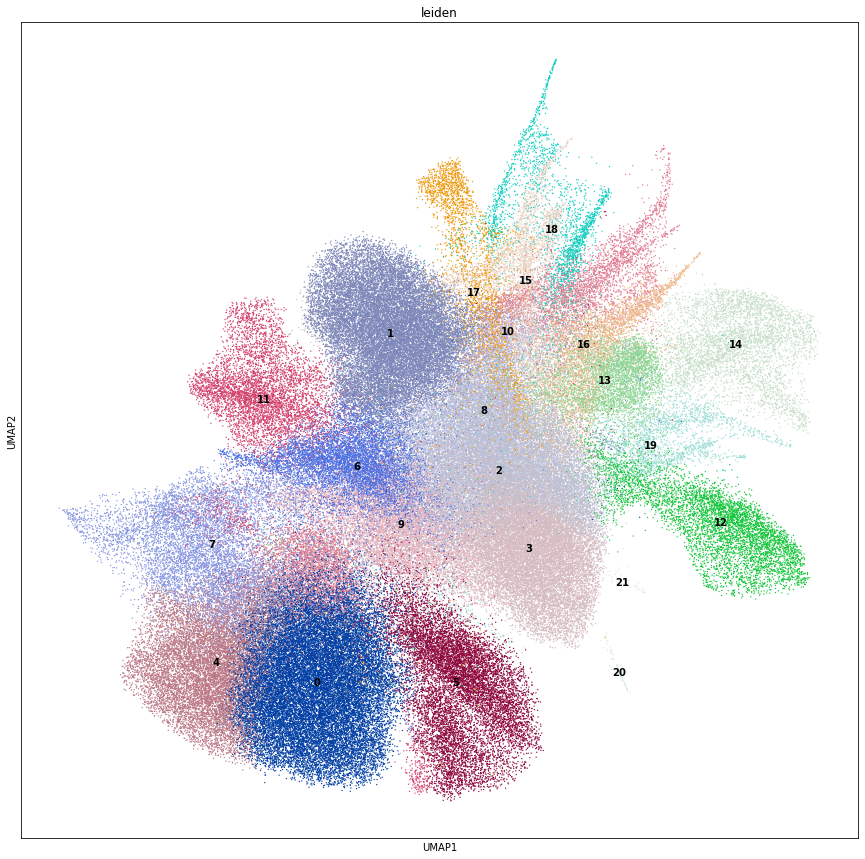

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='leiden', ax=ax, size = 7, legend_loc='on data', save='CellSeg_clusters.png')
plt.show()

In [40]:
adata.write("../outs/R1_region1_CellSeg_cluster-checkpoint.h5ad")

In [2]:
adata = sc.read('../../outs/R1_region1_CellSeg_cluster-checkpoint-mod1.h5ad')

## Running similar pipeline for all other samples

In [3]:
out_root = '../../Data/CellSeg_input/output/quantifications/'
outf = os.listdir(out_root)

In [8]:
def process_seg(sfile):
    dat = pd.read_csv(sfile, index_col=0)
    dat.drop(columns=['BCL-6', 'CD30'], inplace=True)
    dat.index = dat.index.map(str)
    counts = csr_matrix(np.array(dat.iloc[:,9:]))
    adata = ad.AnnData(counts)
    adata.obs_names = dat.index
    adata.var_names = list(dat.columns[9:])
    adata.obs = dat.iloc[:,0:9]
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts > 20, :]
    adata = adata[adata.obs.total_counts < 2000, :]
    sc.pp.normalize_total(adata, target_sum=1e4)
    adata.raw = adata
    sc.pp.scale(adata)
    return adata

In [10]:
for f in outf:
    print('working on {}'.format(f))
    dat_path = os.path.join(out_root, f)
    dat_out = process_seg(dat_path)
    out_name = f[:-4] + '.h5ad'
    dat_out.write(os.path.join('../../outs/simple_h5ad/', out_name))

working on K2_reg1_statistics_growth5_comp.csv
working on K2_reg4_statistics_growth5_comp.csv
working on K2_reg3_statistics_growth5_comp.csv
working on K1_reg4_statistics_growth5_comp.csv
working on K1_reg3_statistics_growth5_comp.csv
working on R1_reg2_statistics_growth5_comp.csv
working on K1_reg2_statistics_growth5_comp.csv
working on K2_reg2_statistics_growth5_comp.csv
working on K1_reg1_statistics_growth5_comp.csv
working on R1_reg3_statistics_growth5_comp.csv
working on R1_reg1_statistics_growth5_comp.csv


In [7]:
outf[0][:-4] + '.h5ad'

'K2_reg1_statistics_growth5_comp.h5ad'

## Identifying clusters
\* more likely
- 0, B_Cell
- 1, CD8_T_Cell
- 2, CD4_T_Cell
- 3, CD4_T_Cell
- 4, B_Cell
- 5, B_Cell_germ
- 6, CD4_T_Cell
- 7, some kind of B_Cell
- 8, CD4_T_Cell
- 9, Treg
- 10, Macrophage / Neutrophil
- 11, 
- 12, pDC
- 13, 
- 14, Endothelial
- 15, Lymphatics
- 16, Macrophage
- 17, cDC1
- 18, cDC2
- 19, fDC
- 20, CD4_T_Cell / garbage
- 21, CD4_T_Cell / garbage


missing plasma, neutrophil

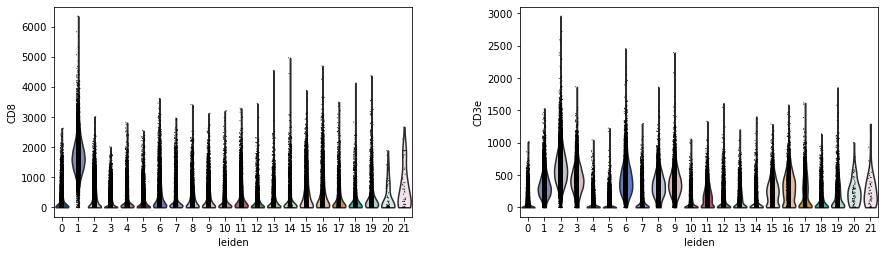

In [36]:
# CD8 t cell
sc.pl.violin(adata, ['CD8', 'CD3e'], groupby='leiden')

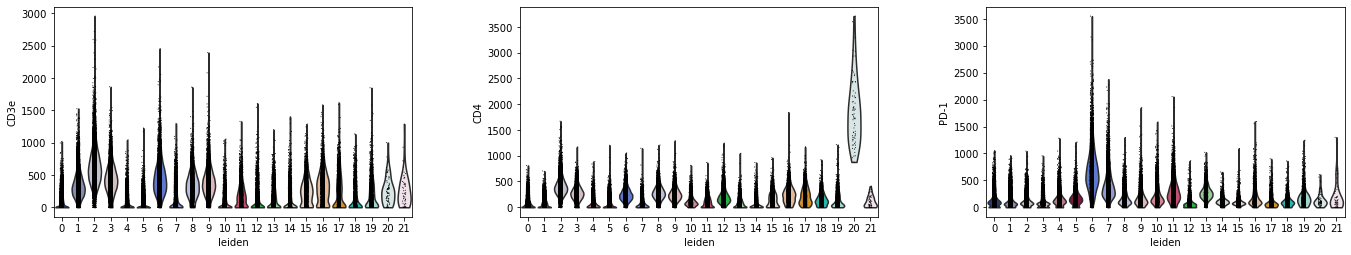

In [5]:
# CD4 t cell, Treg
sc.pl.violin(adata, ['CD3e', 'CD4', 'PD-1'], groupby='leiden')
# sc.pl.violin(adata, ['FOXP3', 'CD4', 'CD25'], groupby='leiden')

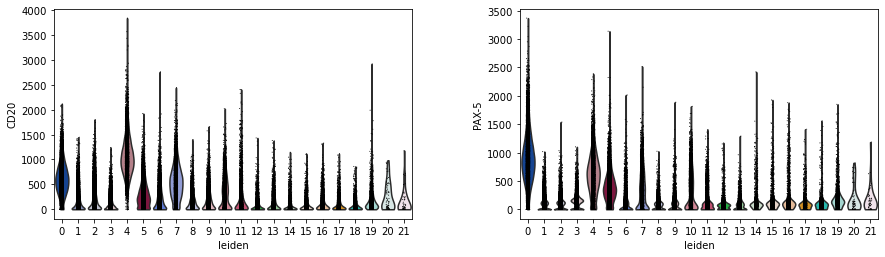

In [7]:
# B Cells
sc.pl.violin(adata, ['CD20', 'PAX-5'], groupby='leiden')
# sc.pl.violin(adata, ['PAX-5', 'BCL-2', 'Ki67'], groupby='leiden')

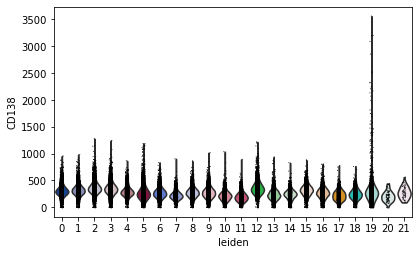

In [9]:
# Plasma cells
sc.pl.violin(adata, ['CD138'], groupby='leiden')

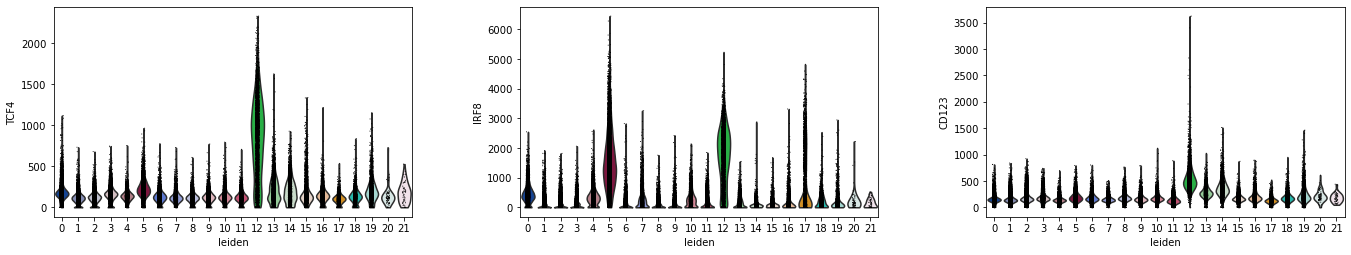

In [45]:
# pDCs
sc.pl.violin(adata, ['TCF4', 'IRF8', 'CD123'], groupby='leiden')

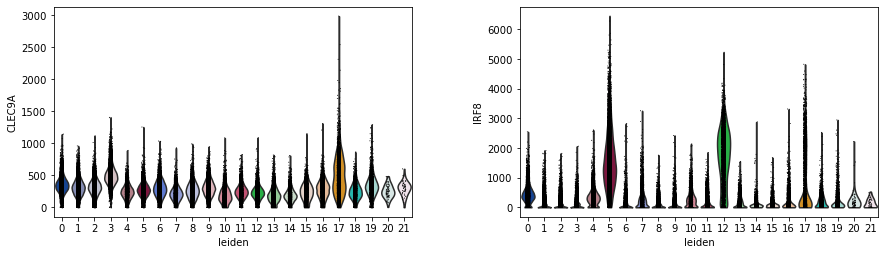

In [46]:
# cDC1
sc.pl.violin(adata, ['CLEC9A', 'IRF8'], groupby='leiden')

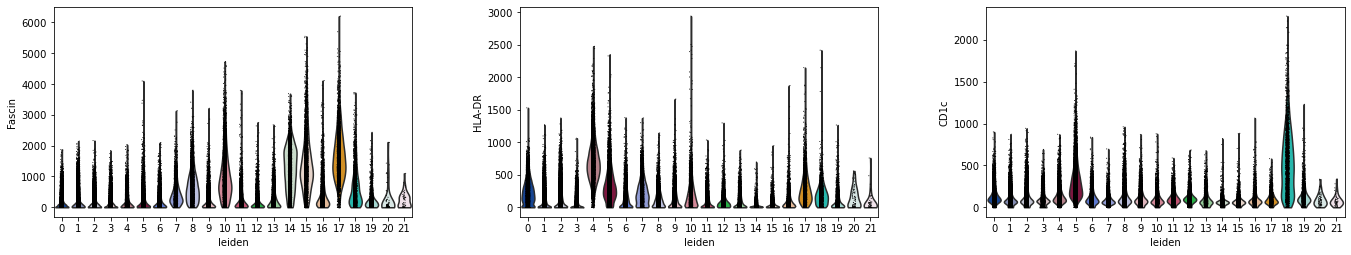

In [47]:
# cDC2
sc.pl.violin(adata, ['Fascin', 'HLA-DR', 'CD1c'], groupby='leiden')

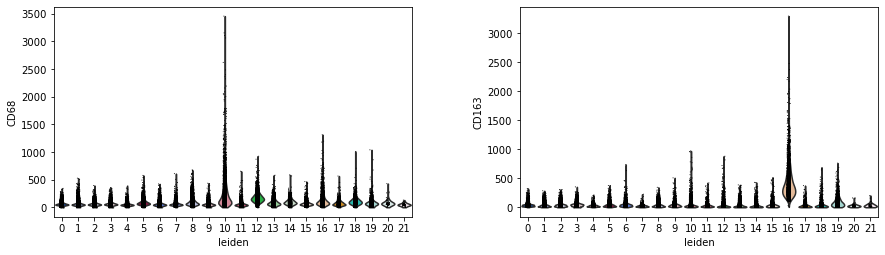

In [48]:
# macrophage
sc.pl.violin(adata, ['CD68', 'CD163'], groupby='leiden')

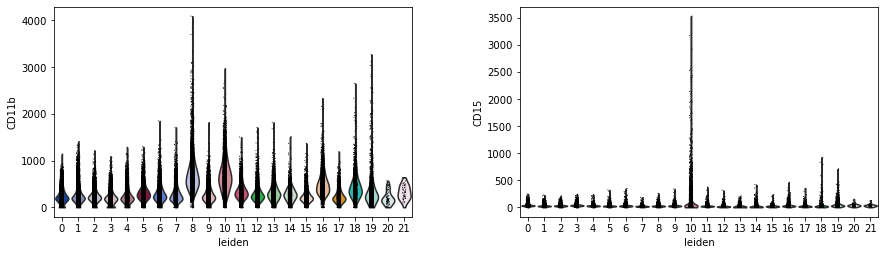

In [49]:
# Neutrophil
sc.pl.violin(adata, ['CD11b', 'CD15'], groupby='leiden')

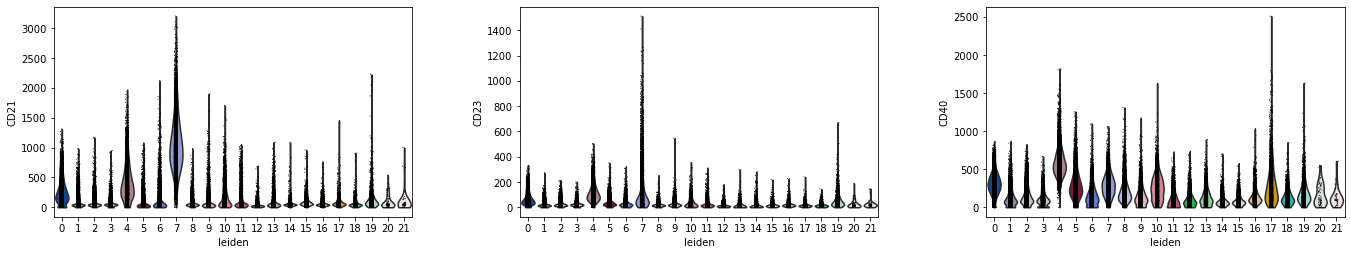

In [50]:
# fDC
sc.pl.violin(adata, ['CD21', 'CD23', 'CD40'], groupby='leiden')

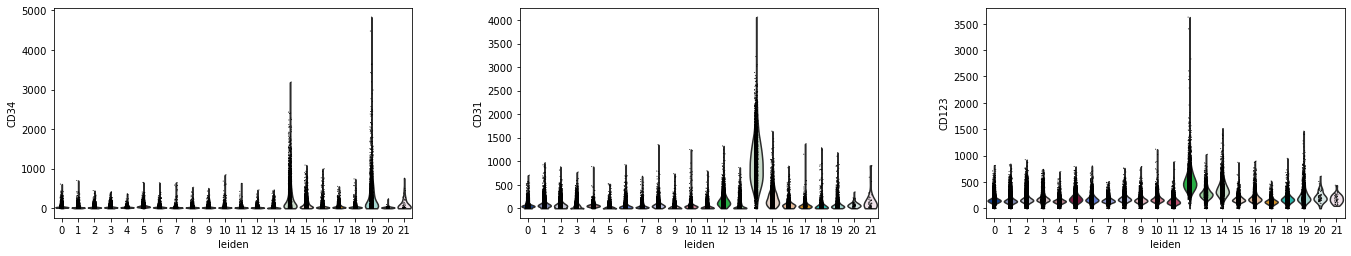

In [51]:
# Vasculature
sc.pl.violin(adata, ['CD34', 'CD31', 'CD123'], groupby='leiden')

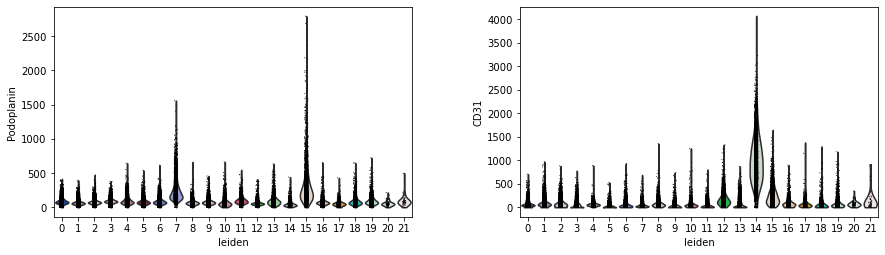

In [52]:
# Lymphatics
sc.pl.violin(adata, ['Podoplanin', 'CD31'], groupby='leiden')

In [34]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:3

In [78]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).iloc[0:5, 0:10]

0      1      2       3       4         5     6           7       8  \
0   PAX-5    CD8    CD4    CD10    CD40      IRF8  PD-1        CD21   CD11b   
1    CD20  BCL-2    CD5    DAPI    CD20      CD1c  CD69  Podoplanin   CD11c   
2  CD45RA   CD3e   CD3e  CLEC9A  HLA-DR      IRF4  CD45        PD-1     CD4   
3    CD40  CD138   CD45   FOXP3    CD23  Mac2Gal3  CD3e        CD20  Fascin   
4    DAPI    CD5  CD138   CD11c  CD45RA    HLA-DR  ICOS        CD23    CD3e   

       9  
0  FOXP3  
1   CD25  
2    CD5  
3   ICOS  
4  CD134

### More fine-grained annotation
- 0, unknown_cycling
- 1, pDC
- 2, cDC2
- 3, fDC
- 4, Macrophage
- 5, fDC
- 6, Tfh
- 7, unknown
- 8, B_Cell_germ
- 9, fDC
- 10, unknown_cycling
- 11, Neutrophil
- 12, unknown

In [7]:
# doing more fine-grained annotation
adata_sub = adata[adata.obs['leiden'].isin(('7', '10', '11', '13')), :]

In [8]:
sc.tl.pca(adata_sub, svd_solver='arpack')

In [9]:
sc.pp.neighbors(adata_sub)
sc.tl.umap(adata_sub)
sc.tl.leiden(adata_sub)

In [10]:
sc.tl.leiden(adata_sub, resolution=0.75)

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


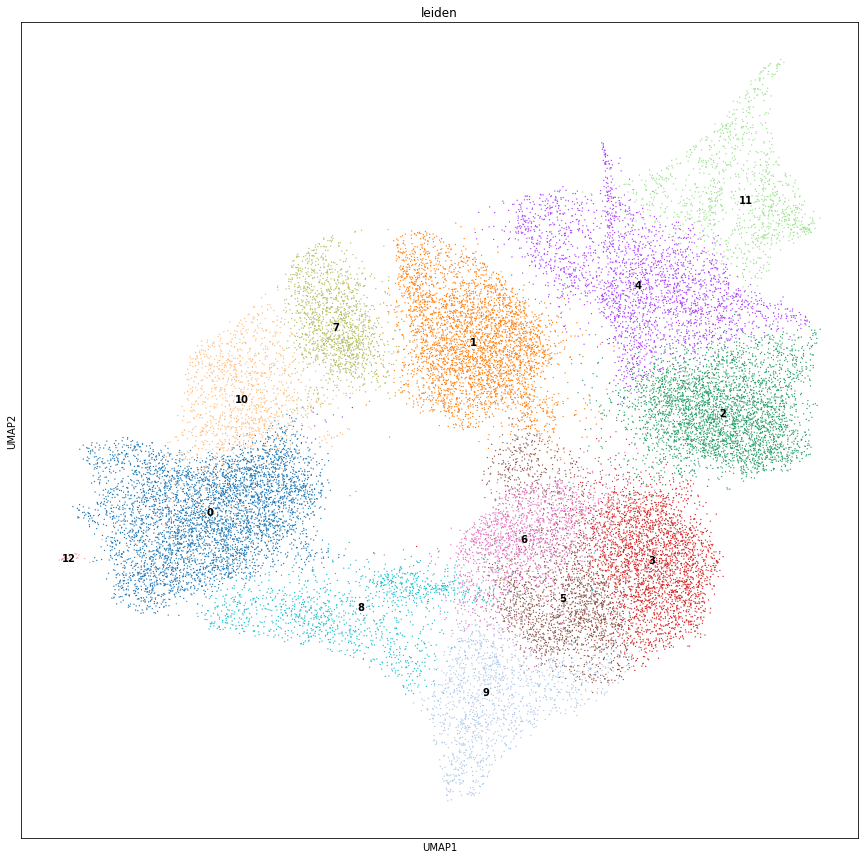

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata_sub, color='leiden', ax=ax, size = 7, legend_loc='on data')
plt.show()

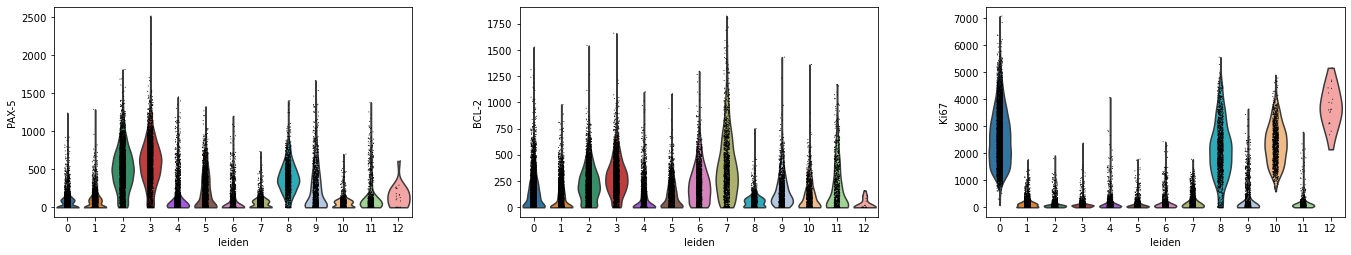

In [93]:
# B cell
# sc.pl.violin(adata_sub, ['CD20', 'PAX-5'], groupby='leiden')
sc.pl.violin(adata_sub, ['PAX-5', 'BCL-2', 'Ki67'], groupby='leiden')

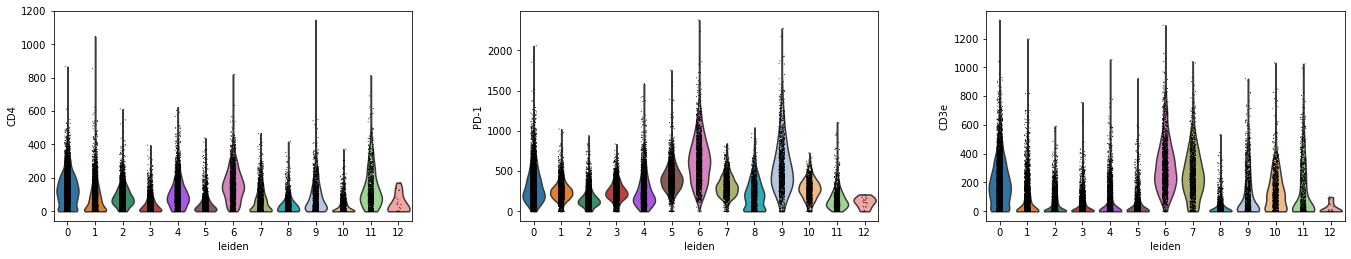

In [72]:
# T cell
sc.pl.violin(adata_sub, ['CD4', 'PD-1', 'CD3e'], groupby='leiden')

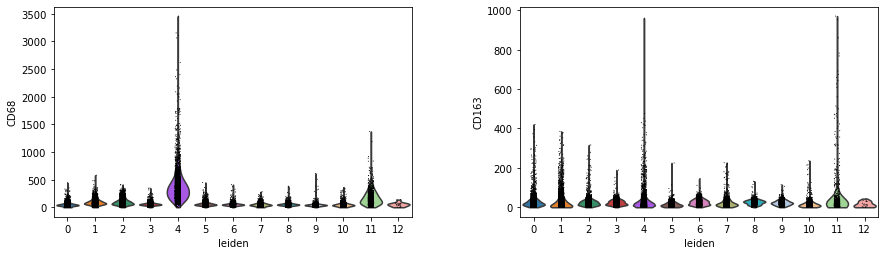

In [62]:
# macrophage
sc.pl.violin(adata_sub, ['CD68', 'CD163'], groupby='leiden')

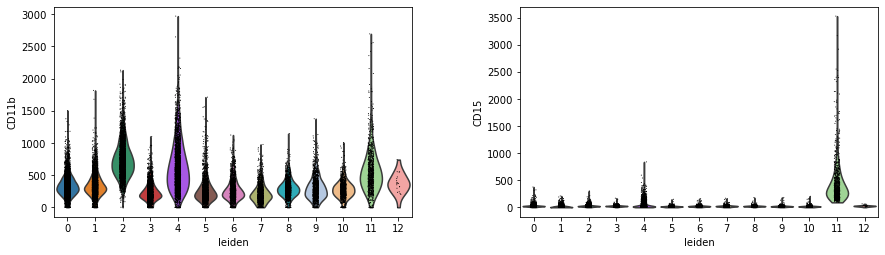

In [63]:
# Neutrophil
sc.pl.violin(adata_sub, ['CD11b', 'CD15'], groupby='leiden')

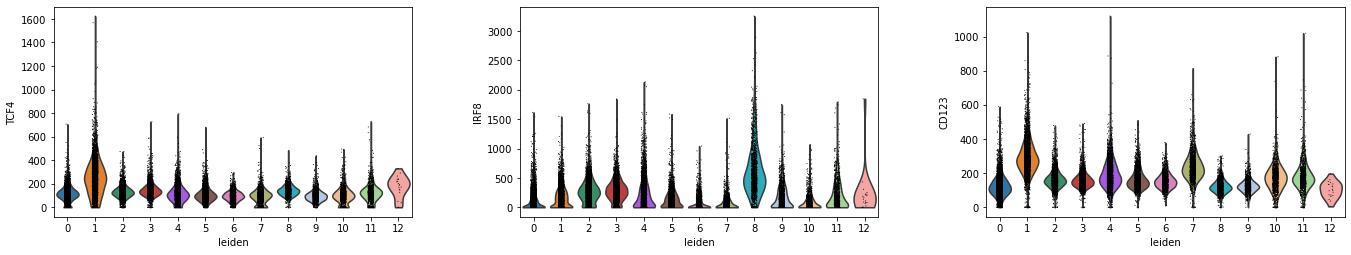

In [64]:
# pDCs
sc.pl.violin(adata_sub, ['TCF4', 'IRF8', 'CD123'], groupby='leiden')

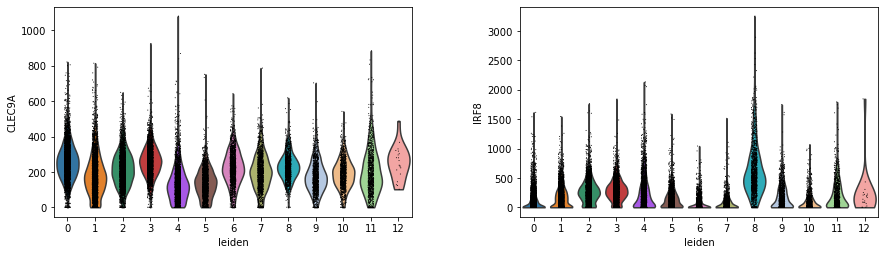

In [65]:
# cDC1
sc.pl.violin(adata_sub, ['CLEC9A', 'IRF8'], groupby='leiden')

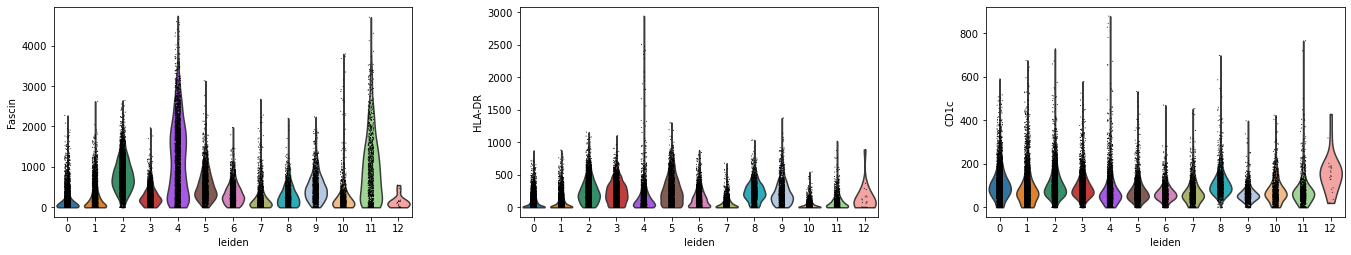

In [66]:
# cDC2
sc.pl.violin(adata_sub, ['Fascin', 'HLA-DR', 'CD1c'], groupby='leiden')

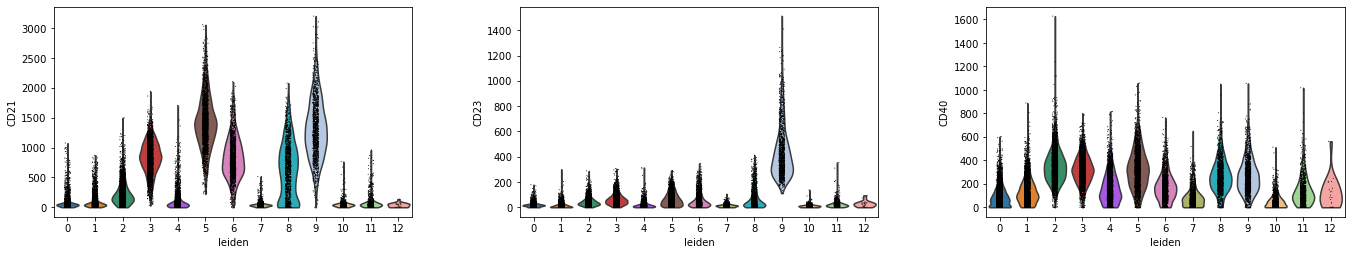

In [67]:
# fDC
sc.pl.violin(adata_sub, ['CD21', 'CD23', 'CD40'], groupby='leiden')

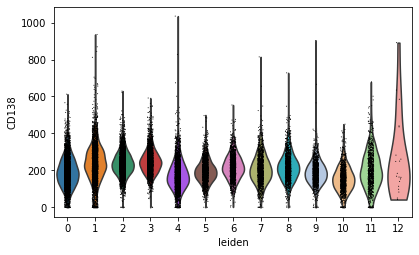

In [68]:
# Plasma cells
sc.pl.violin(adata_sub, ['CD138'], groupby='leiden')

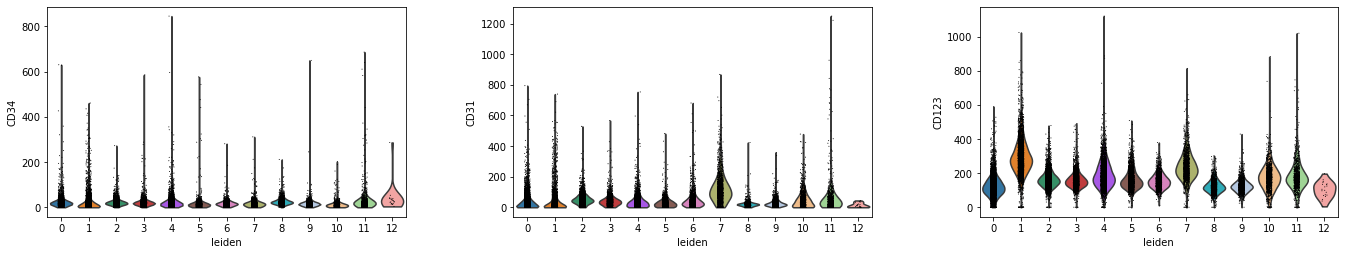

In [69]:
# Vasculature
sc.pl.violin(adata_sub, ['CD34', 'CD31', 'CD123'], groupby='leiden')

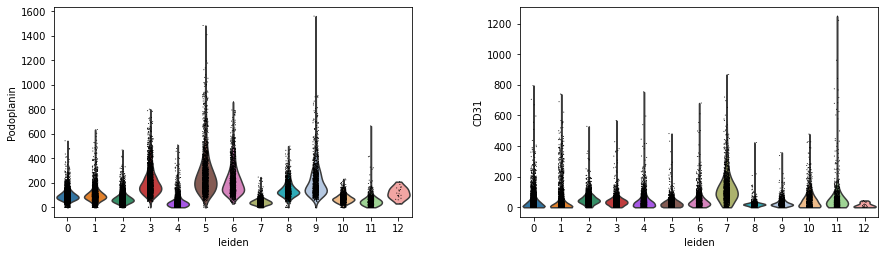

In [70]:
# Lymphatics
sc.pl.violin(adata_sub, ['Podoplanin', 'CD31'], groupby='leiden')

In [73]:
sc.tl.rank_genes_groups(adata_sub, 'leiden', method='t-test')

/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/smithd30/software/anaconda3/envs/scanpy-basic/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [74]:
pd.DataFrame(adata_sub.uns['rank_genes_groups']['names']).head(5)

0         1       2       3         4           5           6  \
0   Ki67  Vimentin   CD11b    CD21      CD68        CD21        CD21   
1   CD10     CD123   CD11c   PAX-5    Fascin  Podoplanin        PD-1   
2  CD134  Mac2Gal3    CD40    CD20     CD11b        CD20        CD3e   
3    MPO      TCF4   PAX-5  CD45RA      CD25        CD40        CD45   
4    CD5     CD138  Fascin    CD40  Mac2Gal3        PD-1  Podoplanin   

          7      8           9        10      11     12  
0  Mac2Gal3   Ki67        CD23      Ki67    CD15   Ki67  
1       CD5   IRF8        CD21  Mac2Gal3  Fascin   IRF4  
2    CD45RA   CD20        CD20       MPO    CD68   CD10  
3      CD31  PAX-5        PD-1      CD10   CD11b    MPO  
4      CD3e    MPO  Podoplanin       CD5    CD25  CD134

### Making the annotations

In [14]:
adata.obs['cell_type'] = "unknown"

In [15]:
# From main data...
adata.obs.loc[adata.obs['leiden'].isin(('2','3','6','8','20','21')) , 'cell_type'] = "CD4_T_Cell"
# adata.obs.loc[adata.obs['leiden'] == '6' , 'cell_type'] = "Tfh"
adata.obs.loc[adata.obs['leiden'] == '1' , 'cell_type'] = "CD8_T_Cell"
adata.obs.loc[adata.obs['leiden'].isin(('0', '4')) , 'cell_type'] = "B_Cell"
adata.obs.loc[adata.obs['leiden'] == '5' , 'cell_type'] = "B_Cell_germ"
adata.obs.loc[adata.obs['leiden'] == '9' , 'cell_type'] = "Treg"
adata.obs.loc[adata.obs['leiden'] == '7' , 'cell_type'] = "FDC" 
adata.obs.loc[adata.obs['leiden'] == '15' , 'cell_type'] = "Lymphatics"
adata.obs.loc[adata.obs['leiden'].isin(('14','13')) , 'cell_type'] = "Endothelial"
adata.obs.loc[adata.obs['leiden'] == '12' , 'cell_type'] = "pDC"
adata.obs.loc[adata.obs['leiden'] == '17' , 'cell_type'] = "cDC1"
adata.obs.loc[adata.obs['leiden'] == '18' , 'cell_type'] = "cDC2"
adata.obs.loc[adata.obs['leiden'] == '16' , 'cell_type'] = "Macrophage"


In [16]:
# From subset data...
# adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '1'] , 'cell_type'] = "pDC"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '2'] , 'cell_type'] = "B_Cell"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '6'] , 'cell_type'] = "Tfh"
# adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'].isin(('5','9','3'))] , 'cell_type'] = "fDC"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'].isin(('0','10'))] , 'cell_type'] = "activated_T_Cell"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '4'] , 'cell_type'] = "Macrophage"
adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '11'] , 'cell_type'] = "Neutrophil"
# adata.obs.loc[adata_sub.obs_names[adata_sub.obs['leiden'] == '18'] , 'cell_type'] = "Plasma"

# still missing plasma...

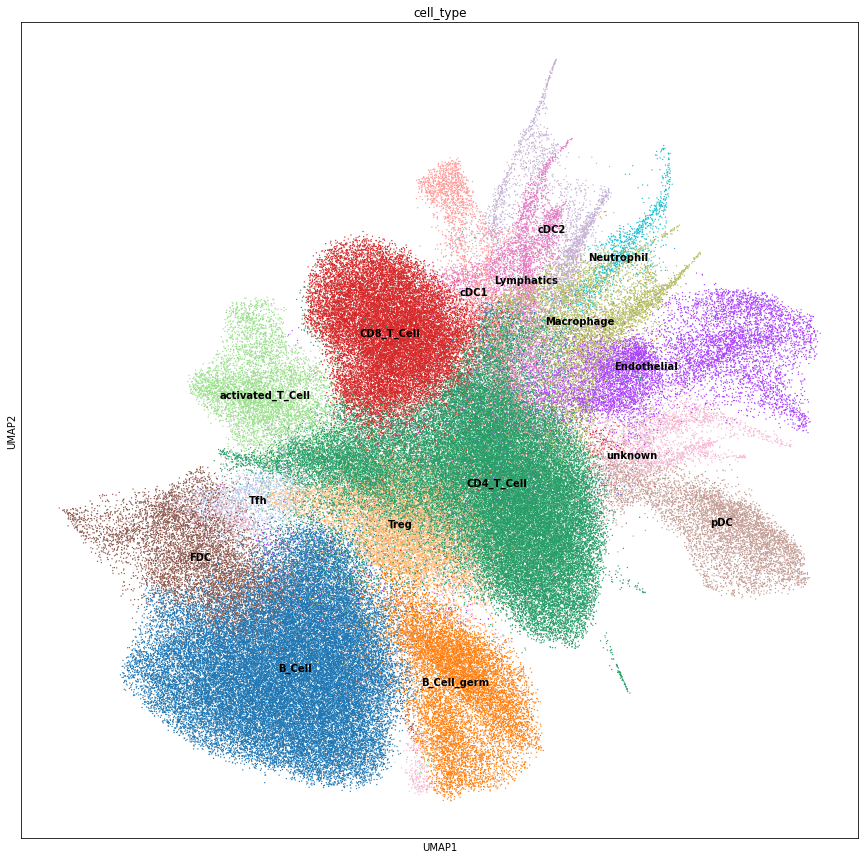

In [3]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='cell_type', size=7, ax=ax, legend_loc='on data')
plt.show()

In [10]:
adata.obs['cell_type'].value_counts()/adata.shape[0]

CD4_T_Cell         0.285751
B_Cell             0.203792
CD8_T_Cell         0.117385
B_Cell_germ        0.060357
pDC                0.049713
fDC                0.047135
Treg               0.044370
Macrophage         0.035724
unknown            0.034105
unknown_cycling    0.030951
Endothelial        0.023972
Lymphatics         0.021000
cDC1               0.017580
cDC2               0.014000
Tfh                0.008902
Neutrophil         0.005263
Name: cell_type, dtype: float64

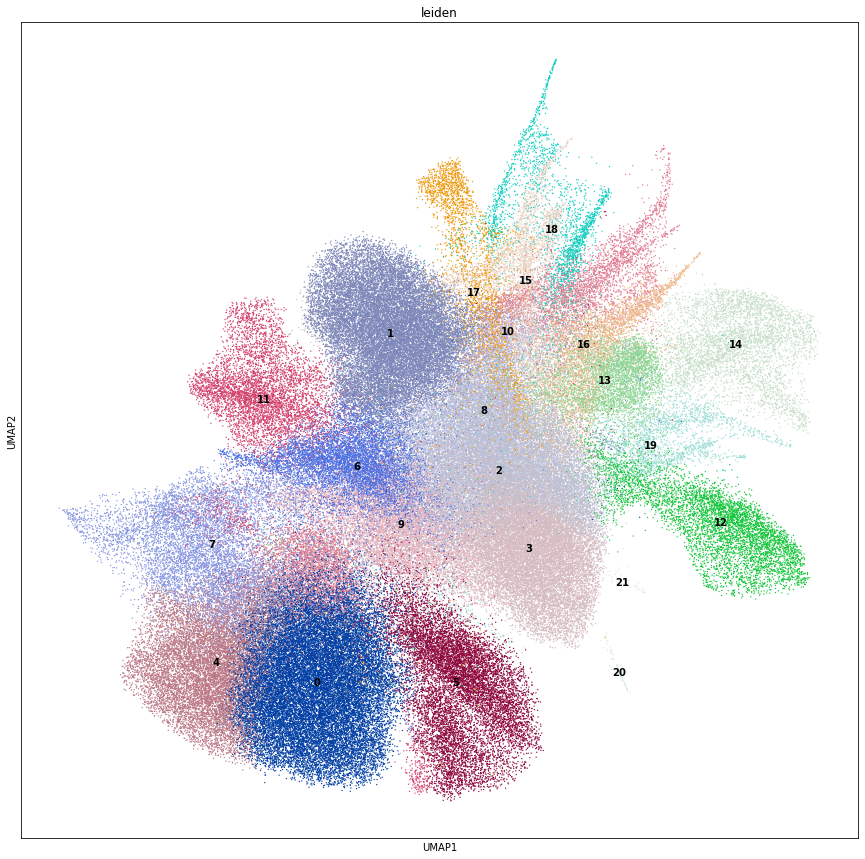

In [4]:
fig, ax = plt.subplots(figsize=(15,15))
sc.pl.umap(adata, color='leiden', ax=ax, size = 7, legend_loc='on data')
plt.show()

In [5]:
adata.obs.to_csv("../../outs/R1_region1_CellSeg_clusters.csv")

In [18]:
adata.write("../../outs/R1_region1_CellSeg_cluster-checkpoint-mod1.h5ad")
# adata = sc.read('../../outs/R1_region1_CellSeg_cluster-checkpoint-mod1.h5ad')

In [ ]:
adata_sub.obs.to_csv("../../outs/R1_region1_CellSeg_subclusters.csv")

In [ ]:
## Revisions
- Drop dead cells, as defined by DAPI signal
- Remove sample specific cell names

In [2]:
adata = sc.read('../../outs/R1_region1_CellSeg_cluster-checkpoint-mod1.h5ad')

In [3]:
adata.obs.cell_type.value_counts() # these look good

CD4_T_Cell          53640
B_Cell              41796
CD8_T_Cell          22035
B_Cell_germ         11330
Endothelial          9592
Treg                 8329
FDC                  6893
Macrophage           6566
activated_T_Cell     5810
pDC                  5654
Lymphatics           3942
unknown              3407
cDC1                 3300
cDC2                 2628
Tfh                  1669
Neutrophil           1125
Name: cell_type, dtype: int64

In [4]:
adata.obs['new_cell_type'] = adata.obs.cell_type.astype(str)

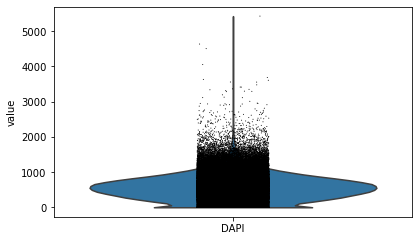

In [6]:
# sc.pl.violin(adata, ['DAPI'], groupby='new_cell_type')
sc.pl.violin(adata, ['DAPI'], )

In [17]:
np.quantile(adata.X[:,adata.var_names == "DAPI"], 0.95)

1.7180688083171844

In [18]:
adata.write("../../outs/cleaned_ref_data/R1_v2.h5ad")